In [1]:
#| default_exp WarmupSGDRScheduler

# WarmupSGDRScheduler

> API details.

In [2]:
#|hide
from nbdev.showdoc import *

In [3]:
#|export
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np

In [4]:
#|export
class WarmupSGDRScheduler(Callback):
    '''Stochastic gradient descent with restarts and warmup learning rate scheduler'''

    def __init__(self, 
                 min_lrs, # Lower bounds of the learning rate
                 max_lrs, # Upper bounds of the learning rate
                 moms, # Lower and upper bounds for the momentum
                 steps_per_epoch, # Steps in each epoch
                 warmup_epochs, # Epochs in each cycle
                 warmup_lr, # Epochs to warmup the learning rate
                 cycle_lengths # Starting learning rate for warmup
        ):
        self.iteration = 0
        self.steps_per_epoch = steps_per_epoch
        self.min_lrs = min_lrs
        self.max_lrs = max_lrs
        self.moms = moms
        self.warmup_epochs = warmup_epochs
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.warmup_lr = warmup_lr
        self.batch_since_restart = 0
        self.restarts = 0
        self.next_restart = cycle_lengths[0]
        self.cycle_lengths = cycle_lengths
        self.num_cycles = len(cycle_lengths)
        self.history = {}

    def clr(self):
        '''Calculate the learning rate'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_lengths[self.restarts])
        lr = self.min_lrs[self.restarts] + 0.5 * (self.max_lrs[self.restarts] - self.min_lrs[self.restarts]) * (1. + np.cos(fraction_to_restart * np.pi))
        return lr
    
    def cmom(self):
        '''Calculate the momentum'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_lengths[self.restarts])
        mom = self.moms[1] + 0.5 * (self.moms[0] - self.moms[1]) * (1. + np.cos(fraction_to_restart * np.pi))
        return mom
    
    def clr_warmup(self):
        '''Calculate the warmup learning rate'''
        fraction_to_start = self.iteration / (self.warmup_steps)
        lr = self.max_lrs[0] + 0.5 * (self.warmup_lr - self.max_lrs[0]) * (1. + np.cos(fraction_to_start * np.pi))
        return lr

    def cmom_warmup(self):
        '''Calculate the warmup momentum'''
        fraction_to_start = self.iteration / (self.warmup_steps)
        mom = self.moms[0] + 0.5 * (self.moms[1] - self.moms[0]) * (1. + np.cos(fraction_to_start * np.pi))
        return mom
    
    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the warmup learning rate value or max_lr at the start of training'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.warmup_lr if self.warmup_lr else self.max_lrs[0])
        K.set_value(self.model.optimizer.beta_1, self.moms[1] if self.warmup_lr else self.moms[0])

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('mom', []).append(K.get_value(self.model.optimizer.beta_1))
        self.history.setdefault('iteration', []).append(self.iteration)
        for k, v in logs.items(): self.history.setdefault(k, []).append(v)
        
        if self.iteration < self.warmup_steps:
            K.set_value(self.model.optimizer.lr, self.clr_warmup())
            K.set_value(self.model.optimizer.beta_1, self.cmom_warmup())
        else:
            self.batch_since_restart += 1
            K.set_value(self.model.optimizer.lr, self.clr())
            K.set_value(self.model.optimizer.beta_1, self.cmom())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 - self.warmup_epochs == self.next_restart:
            self.restarts += 1
            if self.restarts < self.num_cycles:
                self.next_restart += self.cycle_lengths[self.restarts]
                self.batch_since_restart = 0
         
    def plot(self, figsize=(16,5)):
        '''Helper function to quickly inspect the learning rate schedule.'''
        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(121)
        ax1.plot(self.history['iteration'], self.history['lr'])
        ax1.set_title('Learning Rate')
        ax1.set_yscale('log')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Learning rate')
        ax2 = fig.add_subplot(122)
        ax2.plot(self.history['iteration'], self.history['mom'])
        ax2.set_title('Momentum')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Momentum')
        plt.show()

In [5]:
#|hide
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], 
    shuffle_files=True, as_supervised=True, with_info=True)

def normalize_img(image, label): return tf.cast(image, tf.float32) / 255., label
bs = 128

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(bs)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(bs)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_num = 60000
steps_per_epoch = np.ceil(train_num/bs)

2022-07-29 18:09:15.532344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-29 18:09:15.559573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-29 18:09:15.559914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-29 18:09:15.560511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [6]:
schedule = WarmupSGDRScheduler(
                min_lrs = [1e-4, 1e-5, 1e-7],
                max_lrs = [1e-3, 1e-3, 1e-3],
                moms = [.85, .95],
                steps_per_epoch = steps_per_epoch,
                warmup_epochs = 2,
                warmup_lr = 1e-5,
                cycle_lengths = [2, 4, 8]
)

In [7]:
#|hide
epochs = sum(schedule.cycle_lengths)+schedule.warmup_epochs

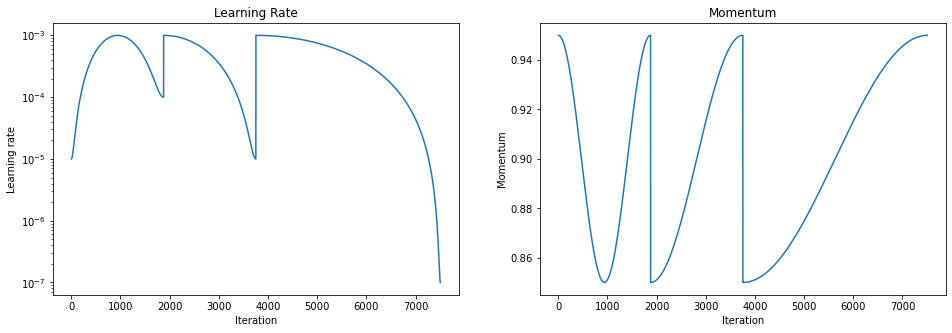

In [8]:
hist = model.fit(ds_train, validation_data=ds_test,
            batch_size=bs, steps_per_epoch=steps_per_epoch, epochs=epochs,
            callbacks=[schedule], verbose=0).history
schedule.plot()

In [9]:
schedule = WarmupSGDRScheduler(
                min_lrs = [1e-7],
                max_lrs = [1e-3],
                moms = [.85, .95],
                steps_per_epoch = steps_per_epoch,
                warmup_epochs = 5,
                warmup_lr = 1e-7,
                cycle_lengths = [5]
)

In [10]:
#|hide
epochs = sum(schedule.cycle_lengths)+schedule.warmup_epochs

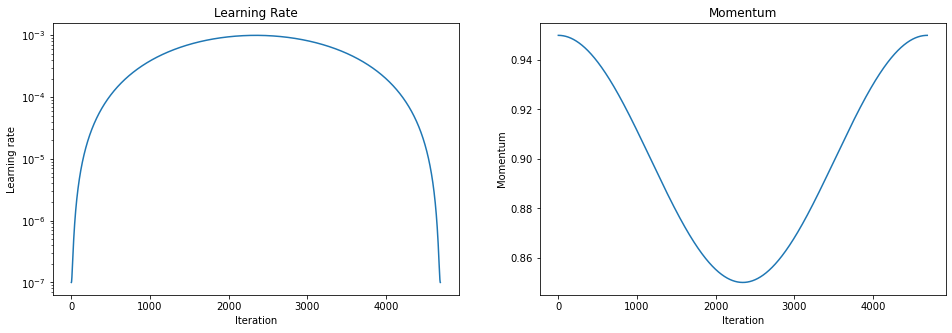

In [11]:
hist = model.fit(ds_train, validation_data=ds_test,
            batch_size=bs, steps_per_epoch=steps_per_epoch, epochs=epochs,
            callbacks=[schedule], verbose=0).history
schedule.plot()

In [12]:
schedule = WarmupSGDRScheduler(
                min_lrs = [1e-4, 1e-5, 1e-7],
                max_lrs = [1e-3, 1e-3, 1e-3],
                moms = [.85, .95],
                steps_per_epoch = steps_per_epoch,
                warmup_epochs = 0,
                warmup_lr = 0,
                cycle_lengths = [2, 4, 8]
)

In [13]:
#|hide
epochs = sum(schedule.cycle_lengths)+schedule.warmup_epochs

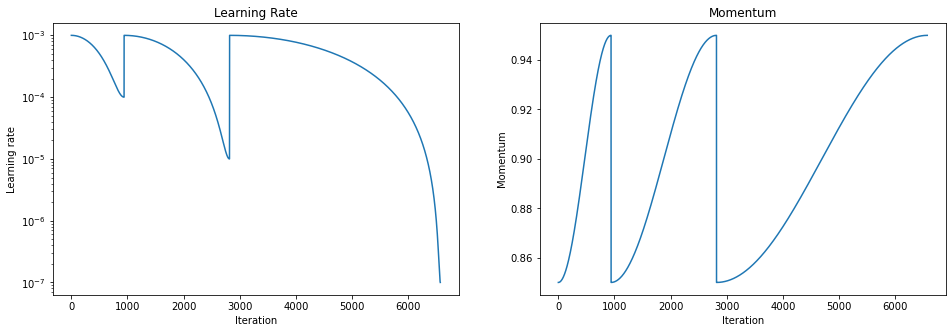

In [14]:
hist = model.fit(ds_train, validation_data=ds_test,
            batch_size=bs, steps_per_epoch=steps_per_epoch, epochs=epochs,
            callbacks=[schedule], verbose=0).history
schedule.plot()